# Algoritmo K-means (Core)

El algoritmo K-means es uno de los métodos de agrupamiento más utilizados en análisis de datos y machine learning. Este algoritmo busca agrupar un conjunto de datos en K grupos o clusters, donde cada grupo está definido por un centroide. En esta actividad, utilizaremos el algoritmo K-means para analizar y segmentar clientes en función de su comportamiento de compra, utilizando el dataset «Mall Customer Segmentation Data» de Kaggle.

Enlace al dataset: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

## Objetivo de la Actividad

El objetivo de esta actividad es utilizar el algoritmo K-means para identificar diferentes grupos de clientes según su comportamiento de compra. El análisis de los clusters resultantes permitirá obtener una mejor comprensión de las características de los clientes, lo que puede ser útil para personalizar estrategias de marketing y mejorar la experiencia del cliente.

## Descripción del Algoritmo K-means

K-means es un algoritmo de aprendizaje no supervisado que agrupa datos en K clusters o grupos, donde K es un número predefinido. Cada cluster se representa mediante un centroide, que es el promedio de todos los puntos de datos en ese grupo. El algoritmo tiene dos fases principales:

1. Asignación de clusters: Cada punto de datos se asigna al centroide más cercano.
2. Actualización de centroides: Se recalcula la posición de los centroides basándose en la media de los puntos de datos asignados a cada cluster.

Este proceso se repite hasta que los centroides no cambian significativamente o se alcanza un número máximo de iteraciones.

## Instrucciones

### 1. Carga del Dataset:

* El dataset contiene información sobre clientes de un centro comercial, como su género, edad, ingresos anuales y puntaje de gasto.
* Utiliza el archivo «Mall_Customers.csv» y cárgalo en tu entorno de trabajo.

### 2. Selección de Variables:

* Para este análisis, selecciona las variables ‘Annual Income (k$)’ y ‘Spending Score (1-100)’, ya que representan características importantes relacionadas con el comportamiento de compra.

### 3. Implementación de K-means:

* Aplica el algoritmo K-means utilizando diferentes valores de K (por ejemplo, K = 3, 4, 5) y observa cómo se agrupan los clientes.
* Visualiza los resultados utilizando gráficos de dispersión que representen los clusters y los centroides.

### 4. Elbow Method:

* Utiliza el método del codo para identificar el número óptimo de clusters. Este método consiste en ejecutar K-means con diferentes valores de K y calcular la suma de errores cuadráticos (SSE). El valor óptimo de K se encuentra donde se produce una disminución significativa en el SSE.

### 5. Interpretación de Clusters:

* Una vez obtenidos los clusters, analiza cada grupo. ¿Qué características tienen en común los clientes de cada cluster? ¿Cómo podrías usar esta información para diseñar estrategias de marketing personalizadas?

### 6. Análisis de Resultados:

* Discute los resultados obtenidos. ¿Qué insights se pueden extraer de los grupos de clientes identificados? ¿Existen patrones o comportamientos comunes?

# Resolución

## 1. Carga del Dataset:

In [41]:
from utils.git_utils import get_repo_file_path
from utils.kaggle_utils import descargar_dataset_kaggle


# Asegúrarse de que el archivo kaggle.json con las credenciales de kaggle
# estén en el directorio base del repositorio.
kaggle_credentials_path = get_repo_file_path("kaggle.json")

descargar_dataset_kaggle(
    "https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python",
    kaggle_credentials_path,
    "../data/",
)

Skipping, found downloaded files in "../data/customer-segmentation-tutorial-in-python" (use force=True to force download)


In [42]:
import pandas as pd


camino_ds = "../data/customer-segmentation-tutorial-in-python/Mall_Customers.csv"
df = pd.read_csv(camino_ds)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [43]:
columnas = df.columns.tolist()

columnas_convertidas_booleanas = []

valores_columnas_booleanas_potenciales = [
    [0, 1],
    [0.0, 1.0],
    ["false", "true"],
    ["no", "yes"],
    ["no", "si"],
    ["N", "Y"],
]


def _convertir_valor_a_booleano(x):
    if x in [0, 0.0, "false", "no", "no", "N"]:
        return False

    if x in [1, 1.0, "true", "yes", "si", "Y"]:
        return True

    return x


for columna in columnas:
    valores_unicos = df[columna].dropna().unique()

    columna_booleana_encontrada = False

    if len(valores_unicos) == 2:
        print(f"Valores de columna '{columna}': {str(valores_unicos)}")

        for posibilidad_valores_booleanos in valores_columnas_booleanas_potenciales:
            if set(valores_unicos) == set(posibilidad_valores_booleanos):
                print(f"La columna '{columna}' es booleana. Será convertida.")
                df[columna] = df[columna].apply(_convertir_valor_a_booleano)
                df[columna] = df[columna].astype("bool")

                columna_booleana_encontrada = True
                break

    if columna_booleana_encontrada:
        columnas_convertidas_booleanas.append(columna)


print(f"Columnas convertidas a booleanas: {str(columnas_convertidas_booleanas)}")

Valores de columna 'Gender': ['Male' 'Female']
Columnas convertidas a booleanas: []


In [44]:
columnas_objeto_cadena = df.select_dtypes(include=["object", "string"]).columns.tolist()

In [45]:
# Se elige el 5% como valor para empezar a considerar una columna como categórica.
# Si se supera esta cantidad la columna se dejará como cadena.
porcentaje_max_columnas_categoricas = 0.05
cant_filas_df = df.shape[0]

columnas_a_excluir = []
columnas_convertidas_a_categoricas = []
columnas_convertidas_a_string = []

for columna in columnas_objeto_cadena:
    valores_unicos = df[columna].dropna().unique().tolist()
    print(f"Cant. únicos para columna '{columna}': {len(valores_unicos)}")
    if len(valores_unicos) <= (porcentaje_max_columnas_categoricas * cant_filas_df):
        
        print(f"Valores únicos columna '{columna}': {str(valores_unicos)}")
        print(f"Se procede a convertir la columna '{columna}' a categórica")
        df[columna] = df[columna].astype("category")
        columnas_convertidas_a_categoricas.append(columna)
    else:
        print(f"No se convierte la columna '{columna}' a categórica, se opta por dejarla como string")
        df[columna] = df[columna].astype("string")
        columnas_convertidas_a_string

    del valores_unicos

print("\n")
print(f"Cant. de columnas analizadas: {len(columnas_objeto_cadena)}")
print(f"Cant. de columnas convertidas a category: {len(columnas_convertidas_a_categoricas)}")
print(f"Cant. de columnas convertidas a string: {len(columnas_convertidas_a_string)}")
print(f"Columnas convertidas a categóricas: {str(columnas_convertidas_a_categoricas)}")
print(f"Columnas convertidas a string: {str(columnas_convertidas_a_string)}")

Cant. únicos para columna 'Gender': 2
Valores únicos columna 'Gender': ['Male', 'Female']
Se procede a convertir la columna 'Gender' a categórica


Cant. de columnas analizadas: 1
Cant. de columnas convertidas a category: 1
Cant. de columnas convertidas a string: 0
Columnas convertidas a categóricas: ['Gender']
Columnas convertidas a string: []


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              200 non-null    int64   
 1   Gender                  200 non-null    category
 2   Age                     200 non-null    int64   
 3   Annual Income (k$)      200 non-null    int64   
 4   Spending Score (1-100)  200 non-null    int64   
dtypes: category(1), int64(4)
memory usage: 6.7 KB


In [47]:
from utils.eda_utils import obtener_estadisticas_datos_nulos


obtener_estadisticas_datos_nulos(df)

,datos sin NAs en q,Na en q,Na en %
CustomerID,200,0,0.0
Gender,200,0,0.0
Age,200,0,0.0
Annual Income (k$),200,0,0.0
Spending Score (1-100),200,0,0.0


In [48]:
duplicados = df.duplicated()

cant_registros_duplicados = duplicados.sum()

print(f"Cant. de Registros Duplicados general: {cant_registros_duplicados}")

Cant. de Registros Duplicados general: 0


## 2. Selección de Variables:

In [49]:
X = df[["Annual Income (k$)", "Spending Score (1-100)"]]

## 3. Implementación de K-means:

Importamos librerías necesarias

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### K = 3

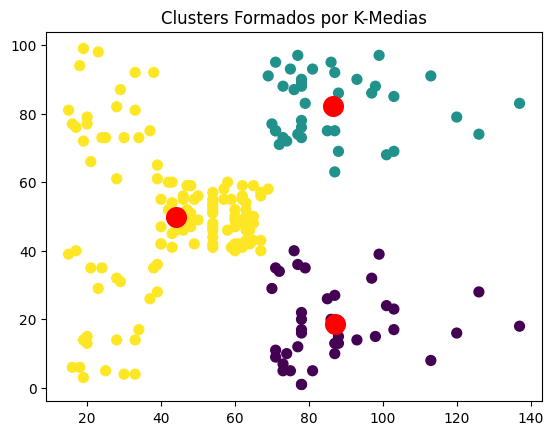

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


# Visualizar los clusters resultantes
plt.scatter(X["Annual Income (k$)"], X["Spending Score (1-100)"], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
plt.title("Clusters Formados por K-Medias")
plt.show()

#### K = 4

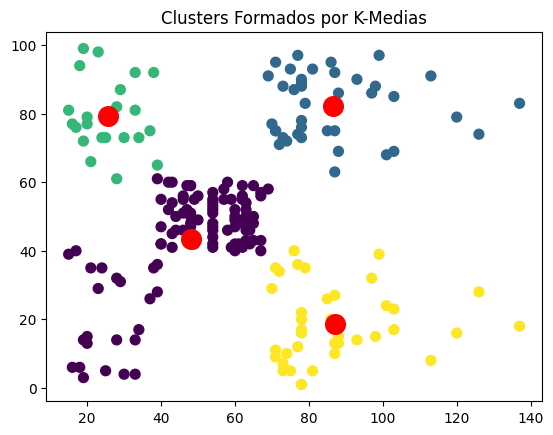

In [52]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


# Visualizar los clusters resultantes
plt.scatter(X["Annual Income (k$)"], X["Spending Score (1-100)"], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
plt.title("Clusters Formados por K-Medias")
plt.show()

#### K = 5

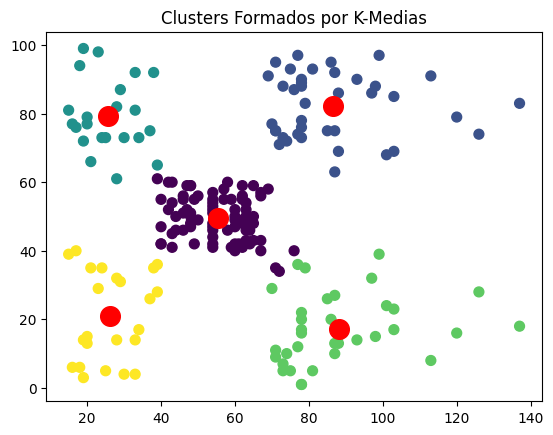

In [53]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


# Visualizar los clusters resultantes
plt.scatter(X["Annual Income (k$)"], X["Spending Score (1-100)"], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
plt.title("Clusters Formados por K-Medias")
plt.show()

## 4. Elbow Method:

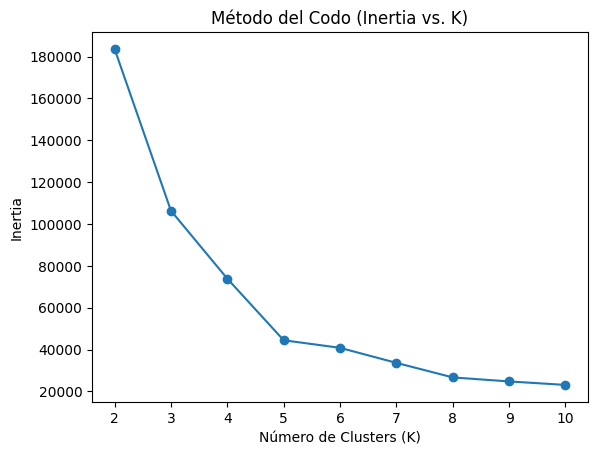

In [54]:
k_values = range(2, 11)

inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.plot(k_values, inertia, marker='o')
plt.title("Método del Codo (Inertia vs. K)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inertia")
plt.show()

Del método del codo, podemos identificar que un buen número de clusters para este dataset es 5.

#### Silhouete Scores

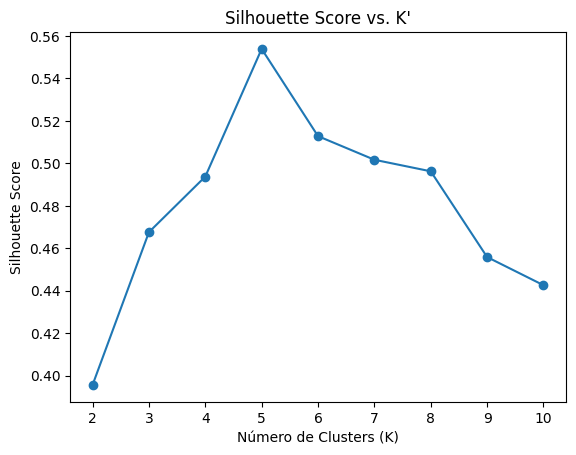

In [55]:
sil_scores = []
k_values = range(2, 11)


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sil_scores.append(silhouette_score(X, kmeans.labels_))


plt.plot(k_values, sil_scores, marker='o')
plt.title("Silhouette Score vs. K'")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

También podemos identificar del silhouette score, que el nro. de clusters más apropiado es k=5, ya que el score se aproxima más al 1.

## 5. Interpretación de Clusters:

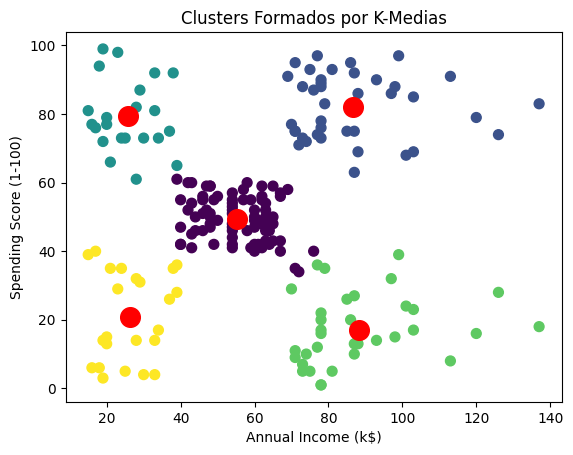

In [56]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


# Visualizar los clusters resultantes
plt.scatter(X["Annual Income (k$)"], X["Spending Score (1-100)"], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
plt.title("Clusters Formados por K-Medias")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

De los clusters, podemos identificar que se van formando los siguientes grupos:

- Cluster 1: Clientes que ganan poco, y tienen un Spending Score Bajo. Este rango va desde 0 a 40k de ingresos anuales aproximadamente. Podemos notar que el su Spending Score tiene un rango de 0 a 40, indicando una alta dispersión para este grupo. Podemos notar que en este cluster por lo general el Spending Score es bastante bajo.
- Cluster 2: Clientes que ganan poco, pero tienen un Spending Score bastante alto. Este rango va de 0 a 40k de ingresos anuales aproximadamente. Al igual que en el Cluster 1, se puede notar una gran dispersión en el spending score, que va desde 60 a 100, con un rango de 60 a 100. Podemos notar también en este cluster que el spending score es relativamente alto
- Cluster 3: Clientes que ganan aproximadamente desde 40k a 80k. En este caso, podemos notar que el Spending Score es un poco mas acotado, de 40 a 60, con un rango de solo 20. Esto nos indica que este grupo de clientes tiene un spending score un poco más consistente. No obstante, no se perciben clientes en este rango que tengan un score muy bueno ni muy malo.
- Cluster 4: Clientes que ganan aproximadamente desde 75k a 140k. En este caso, podemos notar que inicialmente hay una gran dispersión, con un rango de 0 a 40 en spending score. También podemos notar posibles outliers ya en los rangos de ingresos más altos.
- Cluster 5: Clientes que ganan aproximadamente desde 75k a 140k. En este caso, se pueden visualizasr Spending Scores mas altos, con un rango de 60 a 100 en spending score. Identificamos outliers que tienen a tener un spending score más bajo que el resto.

## 6. Análisis de Resultados:

De los resultados podemos destacar:

* En rangos de ingresos bajos (de 0 a 40k) notamos que pueden existir o clientes que tengan muy mal spending score, o muy bueno. No se visualizan spending scores intermedios
* En el caso de ingresos intermedios (40k a 60k) notamos que el spending score es más acotado, aunque con un spending score bastante promedio.
* En rangos de ingresos altos (45k a 140k) notamos un patrón similar al de los ingresos bajos.

Finalmente, con estos datos se puede concluír que los clientes con ingresos bajos y altos tienen una mayor probabilidad de ser mejores compradores, mientras que los clientes con ingresos medios tienen scores solo promedios.